TensorFlow version: 2.19.0

Random Train Image:
Showing image: 075.jpg


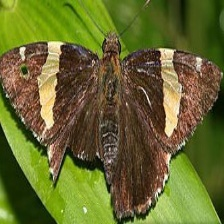


Random Validation Image:
Showing image: 4.jpg


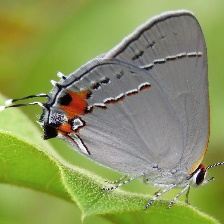


Random Test Image:
Showing image: 4.jpg


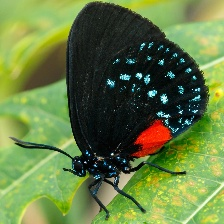

Found 12594 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,434,852 (9.29 MB)

 Trainable params: 176,868 (690.89 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


229/394 ━━━━━━━━━━━━━━━━━━━━ 44s 268ms/step - accuracy: 0.1564 - loss: 3.8160

In [ ]:
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # type: ignore
from tensorflow.keras import layers, models  # type: ignore
import matplotlib.pyplot as plt
from IPython.display import Image, display 
print("TensorFlow version:", tf.__version__)
train_dir = "butterfly_classifier_app/train"
val_dir = "butterfly_classifier_app/valid"
test_dir = "butterfly_classifier_app/test"

img_size = (224, 224)
batch_size = 32


def visualize_random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    selected_image = random.choice(image_files)
    image_path = os.path.join(folder_path, selected_image)
    print(f"Showing image: {selected_image}")
    display(Image(filename=image_path))

print("\nRandom Train Image:")
visualize_random_image(os.path.join(train_dir, random.choice(os.listdir(train_dir))))

print("\nRandom Validation Image:")
visualize_random_image(os.path.join(val_dir, random.choice(os.listdir(val_dir))))

print("\nRandom Test Image:")
visualize_random_image(os.path.join(test_dir, random.choice(os.listdir(test_dir))))

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_data = datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_data = datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(train_data, validation_data=val_data, epochs=10)

test_loss, test_acc = model.evaluate(test_data)
print(f"\nTest Accuracy: {test_acc:.2f}")

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

model.save("butterfly_mobilenetv2_model.h5")
from tensorflow.keras.preprocessing import image  # type: ignore
import numpy as np


model = tf.keras.models.load_model("butterfly_mobilenetv2_model.h5")


class_indices = train_data.class_indices
labels = dict((v, k) for k, v in class_indices.items())


def predict_image(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions, axis=1)[0]
    predicted_class = labels[predicted_index]

    print(f"Predicted Class Index: {predicted_index}")
    print(f"Predicted Class Name: {predicted_class}")

sample_path = os.path.join(test_dir, random.choice(os.listdir(test_dir)), random.choice(os.listdir(os.path.join(test_dir, random.choice(os.listdir(test_dir))))))
print("\nTesting on new image:")
predict_image(sample_path)
